In [10]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import operator
from itertools import islice
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from preprocessing import preprocess

%load_ext autoreload
%autoreload 2

results_path = '../results/'
clustering_method = 'spectral_clustering'
labels_path = '../labels/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

### Jaccard Similarity

In [7]:
df_importance_shap = pd.read_csv(results_path+'shap/'+clustering_method+'/features_importance.csv')
df_importance_lime = pd.read_csv(results_path+'lime/'+clustering_method+'/features_importance.csv')

In [8]:
scaler = MinMaxScaler()
cols = df_importance_shap.columns
df_importance_shap = pd.DataFrame(scaler.fit_transform(df_importance_shap.T).T, columns=cols)

In [9]:
scaler = MinMaxScaler()
cols = df_importance_lime.columns
df_importance_lime = pd.DataFrame(scaler.fit_transform(df_importance_lime.T).T, columns=cols)

In [10]:
zero_data = np.zeros(shape=(len(df_importance_shap)+len(df_importance_shap), len(df_importance_shap)+len(df_importance_shap)))
cols = ['Lime_'+str(i) for i in range(len(df_importance_lime))]
cols.extend(['Shap_'+str(i) for i in range(len(df_importance_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_importance_lime)):
    data.append(list({k: v for k, v in df_importance_lime.iloc[i].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys()))

for i in range(len(df_importance_shap)):
    data.append(take(10, dict(sorted(df_importance_shap.iloc[i].to_dict().items(), key=operator.itemgetter(1),reverse=True))))

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = jaccard(data[i], data[k])

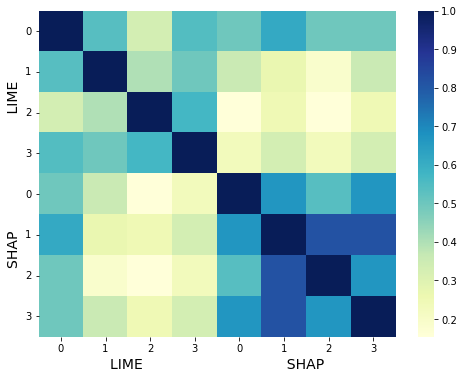

In [11]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(['0', '1', '2', '3', '0', '1', '2', '3'],rotation=0)
g.set_yticklabels(['0', '1', '2', '3', '0', '1', '2', '3'],rotation=0)
plt.show()

In [12]:
df_importance_interC3 = pd.read_csv(results_path+'inter-c3/'+clustering_method+'/features_importance.csv')

In [13]:
best10_shap_cluster3 = take(10, dict(sorted(df_importance_shap.iloc[3].to_dict().items(), key=operator.itemgetter(1),reverse=True)))
best10_lime_cluster3 = list({k: v for k, v in df_importance_lime.iloc[3].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys())
best10_interc3_cluster0 = take(10, dict(sorted(df_importance_interC3.iloc[0].to_dict().items(), key=operator.itemgetter(1),reverse=True)))

In [17]:
zero_data = np.zeros((3, 3))
cols = ['LIME', 'SHAP', 'InterC3']
d = pd.DataFrame(zero_data, columns=cols)

data = [best10_lime_cluster3, best10_shap_cluster3, best10_interc3_cluster0]

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = jaccard(data[i], data[k])

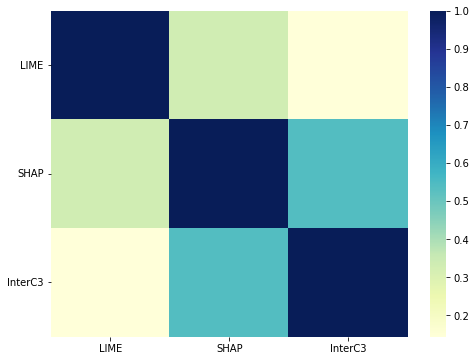

In [18]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
# g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
# g.set_xticklabels(['0', '1', '0', '1'],rotation=0)
g.set_yticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0)
plt.show()

In [19]:
jaccard(best10_shap_cluster3, best10_interc3_cluster0)

0.5384615384615384

### Spearman's Rank Correlation

In [103]:
df_importance = pd.concat([df_importance_shap, df_importance_lime])

In [104]:
df_importance = df_importance.fillna(0)

In [105]:
zero_data = np.zeros(shape=(len(df_importance_shap)+len(df_importance_shap), len(df_importance_shap)+len(df_importance_shap)))
cols = ['Lime_'+str(i) for i in range(len(df_importance_lime))]
cols.extend(['Shap_'+str(i) for i in range(len(df_importance_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_importance_lime)):
    data.append(df_importance.iloc[i+len(df_importance_shap)])

for i in range(len(df_importance_shap)):
    data.append(df_importance.iloc[i])

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

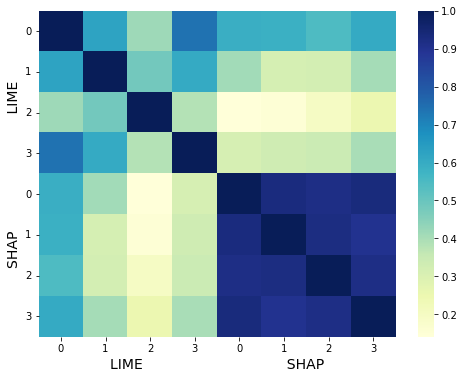

In [106]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(['0', '1', '2', '3', '0', '1', '2', '3'],rotation=0)
g.set_yticklabels(['0', '1', '2', '3', '0', '1', '2', '3'],rotation=0)
plt.show()

In [107]:
df_importance = pd.concat([df_importance, df_importance_interC3])

In [112]:
df_importance = df_importance.fillna(0)

In [114]:
zero_data = np.zeros((3, 3))
cols = ['LIME', 'SHAP', 'InterC3']

d = pd.DataFrame(zero_data, columns=cols)

data = [df_importance.iloc[3+len(df_importance_shap)], df_importance.iloc[3], df_importance.iloc[2*len(df_importance_shap)]]

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

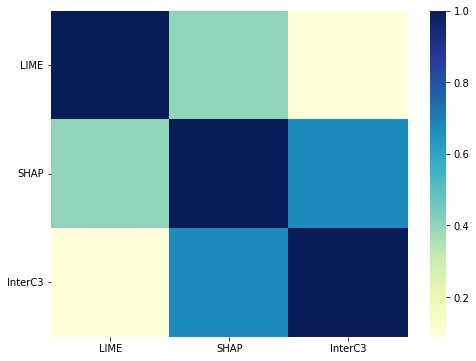

In [115]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
# g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
# g.set_xticklabels(['0', '1', '0', '1'],rotation=0)
g.set_yticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0)
plt.show()

In [55]:
labels_cluster_path = labels_path + 'spectral_clustering/'
labels_masked = np.loadtxt(labels_cluster_path+'masked_hard_fail_perc_0.6_gamma_0.6.txt', dtype=int)
labels_baseline = np.loadtxt(labels_cluster_path+'baseline_cluster_labels_perc_0.6_gamma_0.6.txt', dtype=int)

In [122]:
similarity = {}
for i in range(np.max(labels_masked)+1):
    masked = np.where(labels_masked == i)[0]
    max_similarity = 0
    idx_sim = -1
    for j in range(np.max(labels_baseline)+1):
        sim = jaccard(masked, np.where(labels_baseline == j)[0])
        if sim > max_similarity:
            max_similarity = sim
            idx_sim = j
    similarity[i] = idx_sim

In [123]:
similarity

{0: 3, 1: 2, 2: 2}

In [124]:
best10_shap_cluster3 

['competency_anticipation',
 'competency_strength',
 'total_clicks_problem',
 'competency_alignment',
 'time_sessions mean',
 'student_speed',
 'regularity_periodicity_m1',
 'delay_lecture',
 'time_in__problem sum',
 'frequency_action_Video.Load']

In [125]:
best10_lime_cluster3

['competency_anticipation',
 'competency_strength',
 'student_shape',
 'competency_alignment',
 'delay_lecture',
 'weekly_prop_replayed mean']

In [126]:
best10_interc3_cluster0

['regularity_periodicity_m1',
 'total_clicks',
 'time_sessions sum',
 'time_sessions mean',
 'total_clicks_weekend',
 'total_clicks_problem',
 'time_in__problem sum',
 'competency_strength',
 'competency_anticipation',
 'student_speed']

In [20]:
courses = ['dsp_001', 'hwts_001', 'venture_001', 'villesafricaines_001']

In [29]:
clusters_to_evaluate = []
df_shap = pd.DataFrame()
df_lime = pd.DataFrame()
for course in courses:
    labels_path = '../labels/' + course + '/' + clustering_method + '/'
    
    data_path = '../data/'
    path = data_path + course + '/'
    feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
    metadata = pd.read_csv(data_path + 'metadata.csv')
    percentile = 0.6
    if course == 'dsp_001':
        hard_fail = path + 'feature_labels.csv'
        x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata, hard_fail, hard_fail_file=True)
    else:
        x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, feature_types, metadata)
    X = np.concatenate([x_train, x_val, x_test], axis=0)
    Y = np.concatenate([y_train, y_val, y_test], axis=0)
    if course == 'dsp_001':
        labels = np.loadtxt(labels_path+'baseline_cluster_labels_perc_0.6_gamma_0.6.txt', dtype=int)
    else:
        labels = np.loadtxt(labels_path+'baseline_perc_0.6_gamma_0.6.txt', dtype=int)
    fails = list(labels[np.where(Y == 1)[0]])
    cluster = 0
    max_fails = 0
    for c in range(np.max(labels)+1):
        if fails.count(c) > max_fails:
            max_fails = fails.count(c)
            cluster = c
    clusters_to_evaluate.append(cluster)
    
    df_importance_shap = pd.read_csv(results_path+course+'/shap/'+clustering_method+'/features_importance.csv')
    df_shap = df_shap.append(df_importance_shap.iloc[cluster])
    df_importance_lime = pd.read_csv(results_path+course+'/lime/'+clustering_method+'/features_importance.csv')
    df_lime = df_lime.append(df_importance_lime.iloc[cluster])

In [32]:
df_shap

,competency_anticipation,competency_strength,total_clicks_problem,student_speed,time_in__problem sum,delay_lecture,frequency_action_Video.Load,time_sessions mean,total_clicks_weekend,number_sessions,...,frequency_action_Video.Stop,frequency_action_Video.SeekBackward,frequency_action_Video.SeekForward,frequency_action_Video.SpeedChange,seek_length mean,seek_length std,pause_duration mean,pause_duration std,time_speeding_up mean,time_speeding_up std
3,0.020042,0.014335,0.004460,0.003031,0.002649,0.002894,0.002152,0.003343,0.000777,0.001231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.022216,0.001624,0.001208,0.000347,0.003452,0.001309,0.002673,0.000155,0.001041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000728,0.001414,0.000066,0.000842
1,0.000000,0.002525,0.001424,0.000849,0.001124,0.000633,0.000574,0.000184,0.000078,0.000040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000066,0.000134,0.000312,0.000289
0,0.000000,0.000000,0.019376,0.001027,0.001469,0.000639,0.000352,0.001490,0.000327,0.001921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000318,0.000350,0.001226,0.000688


In [33]:
df_lime

,competency_anticipation,competency_strength,student_shape,competency_alignment,delay_lecture,weekly_prop_replayed mean,time_in__problem sum,student_speed,total_clicks_weekend,total_clicks_problem,...,ratio_clicks_weekend_day,time_speeding_up std,weekly_prop_interrupted mean,weekly_prop_watched mean,time_sessions std,time_speeding_up mean,pause_duration mean,pause_duration std,regularity_periodicity_m1,total_clicks_Video.Load
3,0.199662,0.086149,0.118861,0.145521,0.047762,0.062639,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,0.076345,0.143857,0.080524,NaN,0.040395,NaN,0.033794,NaN,NaN,...,NaN,0.028153,0.032960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.007744,0.003061,0.010002,NaN,0.010897,0.004111,NaN,NaN,0.004221,...,NaN,0.004584,0.006848,NaN,0.00412,0.005024,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,0.031189,0.096768,NaN,NaN,0.050666,0.147429,...,0.058467,0.048594,0.050546,0.045087,NaN,0.046332,NaN,NaN,0.064332,NaN


In [34]:
scaler = MinMaxScaler()
cols = df_shap.columns
df_shap = pd.DataFrame(scaler.fit_transform(df_shap.T).T, columns=cols)

scaler = MinMaxScaler()
cols = df_lime.columns
df_lime = pd.DataFrame(scaler.fit_transform(df_lime.T).T, columns=cols)

In [38]:
zero_data = np.zeros(shape=(len(df_shap)+len(df_shap), len(df_shap)+len(df_shap)))
cols = ['Lime_'+str(i) for i in range(len(df_lime))]
cols.extend(['Shap_'+str(i) for i in range(len(df_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_lime)):
    data.append(list({k: v for k, v in df_lime.iloc[i].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys()))

for i in range(len(df_shap)):
    data.append(take(10, dict(sorted(df_shap.iloc[i].to_dict().items(), key=operator.itemgetter(1),reverse=True))))

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = jaccard(data[i], data[k])

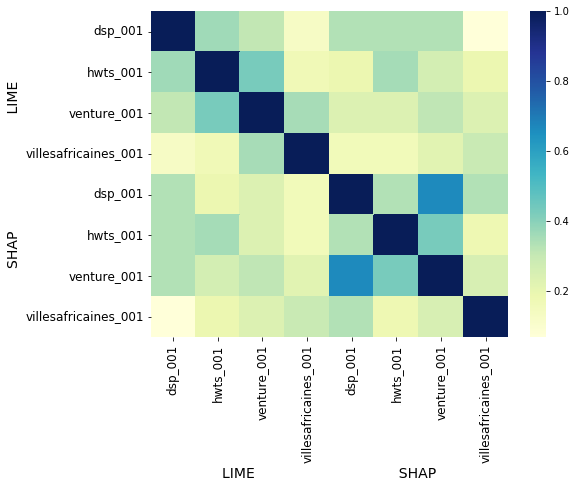

In [45]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(courses+courses,rotation=90, fontsize=12)
g.set_yticklabels(courses+courses, rotation=0, fontsize=12)
plt.show()

In [46]:
df = pd.concat([df_shap, df_lime])

In [47]:
df = df.fillna(0)

In [54]:
df

,competency_anticipation,competency_strength,total_clicks_problem,student_speed,time_in__problem sum,delay_lecture,frequency_action_Video.Load,time_sessions mean,total_clicks_weekend,number_sessions,...,frequency_action_Video.Stop,frequency_action_Video.SeekBackward,frequency_action_Video.SeekForward,frequency_action_Video.SpeedChange,seek_length mean,seek_length std,pause_duration mean,pause_duration std,time_speeding_up mean,time_speeding_up std
0,1.0,0.715248,0.222539,0.151234,0.132176,0.144394,0.107374,0.166785,0.038764,0.061412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,1.000000,0.073081,0.054392,0.015608,0.155394,0.058903,0.120304,0.006957,0.046870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.032760,0.063667,0.002973,0.037911
2,0.0,1.000000,0.563747,0.336067,0.445088,0.250477,0.227315,0.072670,0.031022,0.015877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.026301,0.053032,0.123683,0.114320
3,0.0,0.000000,1.000000,0.053026,0.075832,0.032954,0.018147,0.076888,0.016895,0.099144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016427,0.018064,0.063250,0.035515
0,1.0,0.252713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.429743,0.000000,0.070322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.022670
2,0.0,0.597594,0.147989,0.000000,0.133921,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.250518,0.194407
3,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167555,0.109700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.130271,0.149732


In [48]:
zero_data = np.zeros(shape=(len(df_shap)+len(df_shap), len(df_shap)+len(df_shap)))
cols = ['Lime_'+str(i) for i in range(len(df_lime))]
cols.extend(['Shap_'+str(i) for i in range(len(df_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_lime)):
    data.append(df.iloc[i+len(df_shap)])

for i in range(len(df_shap)):
    data.append(df.iloc[i])

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

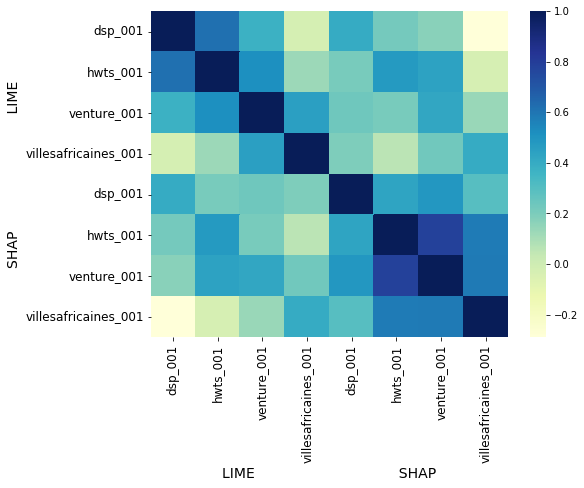

In [50]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set(xlabel='LIME                                SHAP', ylabel='SHAP                          LIME')
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(courses+courses,rotation=90, fontsize=12)
g.set_yticklabels(courses+courses, rotation=0, fontsize=12)
plt.show()

In [51]:
df_lime

,competency_anticipation,competency_strength,student_shape,competency_alignment,delay_lecture,weekly_prop_replayed mean,time_in__problem sum,student_speed,total_clicks_weekend,total_clicks_problem,...,ratio_clicks_weekend_day,time_speeding_up std,weekly_prop_interrupted mean,weekly_prop_watched mean,time_sessions std,time_speeding_up mean,pause_duration mean,pause_duration std,regularity_periodicity_m1,total_clicks_Video.Load
0,1.0,0.252713,0.468066,0.643576,0.0,0.097938,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.429743,1.000000,0.465037,NaN,0.126082,NaN,0.070322,NaN,NaN,...,NaN,0.022670,0.063274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.597594,0.000000,0.885802,NaN,1.000000,0.133921,NaN,NaN,0.147989,...,NaN,0.194407,0.483283,NaN,0.135102,0.250518,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.0,0.564169,NaN,NaN,0.167555,1.000000,...,0.234668,0.149732,0.166522,0.119565,NaN,0.130271,NaN,NaN,0.285122,NaN
